In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np
from scipy.stats import iqr
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
from predict import extract_features


In [17]:
# training parameters
epochs = 20
batch_size = 8
loss = tf.keras.losses.MeanAbsoluteError()
opt = tf.keras.optimizers.Adam()
input_path = '../../data/data_v2/'
output_path = './model/'


In [18]:
# load data
x_train = pickle.load(open(input_path+'/x_train.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/y_train.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/sizes_train.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/x_test.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/y_test.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/sizes_test.pkl', 'rb'))


In [19]:
# standardize
x_train = [np.array(i) for i in x_train]
x_val = [np.array(i) for i in x_val]

y_train = [(i-j.mean())/j.std() for i,j in zip(y_train, x_train)]
y_val = [(i-j.mean())/j.std() for i,j in zip(y_val, x_val)]
x_train = [(i-i.mean())/i.std() for i in x_train]
x_val = [(i-i.mean())/i.std() for i in x_val]


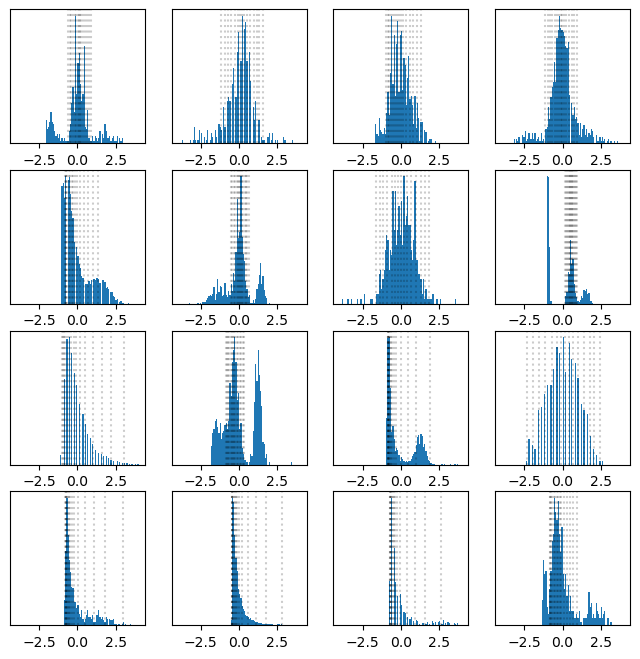

In [20]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
idx = np.random.choice(len(x_train), nr*nc)
bins = np.linspace(-4, 4, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_train[idx[i]], bins, density=True)
    for j in range(len(y_train[0])):
        plt.axvline(y_train[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

In [21]:
# optionally add size prediction

y_train = np.array(y_train)
y_train = np.hstack([
    y_train, 
    np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
])

y_val = np.array(y_val)
y_val = np.hstack([
    y_val, 
    np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
])


In [23]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train)
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val)


In [24]:
x_train.shape

(9000, 100, 1)

In [25]:
y_train.shape


(9000, 16)

In [26]:
# standardize

scalery = RobustScaler()
y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [27]:
# define model

inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=7, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
o = tf.keras.layers.Dense(y_val.shape[1], activation='linear')(x)
model = tf.keras.models.Model(inputs, o)

# define loss and optimizer
model.compile(loss = loss,
              optimizer = opt)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 32)            192       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 48, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 44, 64)            10304     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 22, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 64)            2873

In [28]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



Epoch 1/20

Epoch 1: val_loss improved from inf to 0.18312, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 4s - loss: 0.2627 - val_loss: 0.1831 - 4s/epoch - 3ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.18312 to 0.16951, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1858 - val_loss: 0.1695 - 3s/epoch - 2ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.16951 to 0.15306, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1671 - val_loss: 0.1531 - 3s/epoch - 2ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.15306 to 0.14714, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1532 - val_loss: 0.1471 - 3s/epoch - 2ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.14714 to 0.14438, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1460 - val_loss: 0.1444 - 3s/epoch - 2ms/step
Epoch 6/20

Epoch 6: val_loss improved from 0.14438 to 0.14333, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1402 - val_loss: 0.1433 - 3s/epoch - 2ms/step
Epoch 7/20

Epoch 7: val_loss did not improve from 0.14333
1125/1125 - 2s - loss: 0.1363 - val_loss: 0.1443 - 2s/epoch - 2ms/step
Epoch 8/20

Epoch 8: val_loss improved from 0.14333 to 0.14066, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1318 - val_loss: 0.1407 - 3s/epoch - 2ms/step
Epoch 9/20

Epoch 9: val_loss improved from 0.14066 to 0.13914, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1277 - val_loss: 0.1391 - 3s/epoch - 3ms/step
Epoch 10/20

Epoch 10: val_loss improved from 0.13914 to 0.13524, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1247 - val_loss: 0.1352 - 3s/epoch - 2ms/step
Epoch 11/20

Epoch 11: val_loss improved from 0.13524 to 0.13024, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1212 - val_loss: 0.1302 - 3s/epoch - 2ms/step
Epoch 12/20

Epoch 12: val_loss did not improve from 0.13024
1125/1125 - 2s - loss: 0.1186 - val_loss: 0.1467 - 2s/epoch - 2ms/step
Epoch 13/20

Epoch 13: val_loss did not improve from 0.13024
1125/1125 - 2s - loss: 0.1160 - val_loss: 0.1336 - 2s/epoch - 2ms/step
Epoch 14/20

Epoch 14: val_loss did not improve from 0.13024
1125/1125 - 2s - loss: 0.1149 - val_loss: 0.1310 - 2s/epoch - 2ms/step
Epoch 15/20

Epoch 15: val_loss improved from 0.13024 to 0.12927, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


1125/1125 - 3s - loss: 0.1105 - val_loss: 0.1293 - 3s/epoch - 2ms/step
Epoch 16/20

Epoch 16: val_loss did not improve from 0.12927
1125/1125 - 2s - loss: 0.1095 - val_loss: 0.1334 - 2s/epoch - 2ms/step
Epoch 17/20

Epoch 17: val_loss did not improve from 0.12927
1125/1125 - 2s - loss: 0.1070 - val_loss: 0.1304 - 2s/epoch - 2ms/step
Epoch 18/20

Epoch 18: val_loss did not improve from 0.12927
1125/1125 - 2s - loss: 0.1052 - val_loss: 0.1294 - 2s/epoch - 2ms/step
Epoch 19/20

Epoch 19: val_loss did not improve from 0.12927
1125/1125 - 2s - loss: 0.1040 - val_loss: 0.1307 - 2s/epoch - 2ms/step
Epoch 20/20

Epoch 20: val_loss did not improve from 0.12927
1125/1125 - 2s - loss: 0.1026 - val_loss: 0.1324 - 2s/epoch - 2ms/step


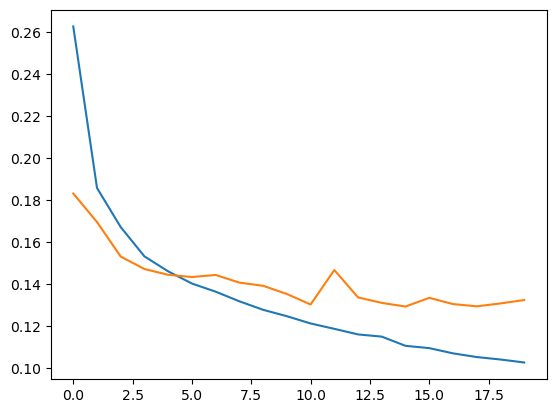

In [29]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);


In [30]:
# save scalers
with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
